In [1]:
import torch
from tqdm import tqdm
import torch.nn as nn
from matplotlib import pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=64, device=device):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device
        
        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1-self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0) #cumulative product.
        
    def prepare_noise_schedule(self, mode='linear'):
        if mode=='linear':
            return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)
        if mode=='cos':
            #TODO : open ai cos schedule
            pass
        
    def noise_images(self, x, t):
        # Generate X_t in a single step as described in the paper
        # x_t = sqrt(alpha_hat)*x_0 + sqrt(1-alpha_hat)*e
        e = torch.randn_like(x)
        x_t = x*torch.sqrt(self.alpha_hat[t])[:, None, None, None] + torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]*e # ?
        return x_t, e
        
    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))
    
    def sample(self, model, n):
        model.eval()
        # Algo 2 - Sampling
        with torch.no_grad():
            x = torch.randn((n, 1, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i>1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1/torch.sqrt(alpha)*(x-((1-alpha)/torch.sqrt(1-alpha_hat))*predicted_noise)+torch.sqrt(beta)*noise
            model.train()
            x = (x.clamp(-1,1)+1)/2
            x = (x*255).type(torch.uint8)
            return x

In [3]:
class UNet(nn.Module):
    def __init__(self, c_in=1, c_out=1, time_dim=256, device=device):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 14)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 7)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 4)
        
        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)
        
        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 7)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 14)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64,28)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)
        
    # Sinosoidal encoding - further read
    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (10000**(torch.arange(0, channels, 2, device=self.device).float() / channels))
        
        pos_enc_a = torch.sin(t.repeat(1, channels // 2)*inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels//2)*inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc
    
    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)
        
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)
        
        # Bottleneck
        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)
        
        # Decoder
        #print(x4.size())
        #print(x3.size())
        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        return self.outc(x)  

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False)
        self.norm1 = nn.GroupNorm(1, mid_channels)
        self.act = nn.GELU() ## Try Relu, leakyReLU
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.norm2 = nn.GroupNorm(1, out_channels)
        self.residual = residual
        
    def forward(self, x):
        x2 = self.conv1(x)
        x2 = self.norm1(x2)
        x2 = self.act(x2)
        x2 = self.conv2(x2)
        x2 = self.norm2(x2)
        if self.residual:
            return self.act(x+x2)
        else:
            return x2

In [5]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxPool = nn.MaxPool2d(2)
        self.doubleConv1 = DoubleConv(in_channels, in_channels, residual=True)
        self.doubleConv2 = DoubleConv(in_channels, out_channels)
        
        self.act = nn.SiLU()
        self.linear = nn.Linear(emb_dim, out_channels)
        
    def forward(self, x, t):
        x = self.maxPool(x)
        x = self.doubleConv1(x)
        x = self.doubleConv2(x)
        #print(x.size())
        emb = self.act(t)
        emb = self.linear(emb)[:, :, None, None].repeat(1,1,x.shape[-2], x.shape[-1])
        #print(emb.size())
        
        return x+emb  

In [6]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        
        #self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.doubleConv1 = DoubleConv(in_channels, in_channels, residual=True)
        self.doubleConv2 = DoubleConv(in_channels, out_channels, in_channels//2)
        self.act = nn.SiLU()
        self.linear = nn.Linear(emb_dim, out_channels)
        
    def forward(self, x, skip_x, t):
        #print(x.size())
        x = self.up(x)
        #print(x.size())
        if x.shape[-2:] != skip_x.shape[-2:]:
            x = nn.functional.interpolate(x, size=skip_x.shape[-2:], mode='bilinear', align_corners=True)
            #print(x.size())
        x = torch.cat([skip_x, x], dim=1)
        x = self.doubleConv1(x)
        x = self.doubleConv2(x)
        emb = self.act(t)
        emb = self.linear(emb)[:, :, None, None].repeat(1,1,x.shape[-2], x.shape[-1])
        return x+emb

In [7]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.linear = nn.Linear(channels, channels)
        self.act = nn.GELU()
    
    def forward(self, x):
        b, c, h, w = x.shape
        x = x.view(b, c, h*w).permute(0,2,1)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        x = self.ln(attention_value)
        x = self.linear(x)
        x = self.act(x)
        x = self.linear(x)
        attention_value = x + attention_value
        
        return attention_value.permute(0, 2, 1).view(b, c, h, w)

In [8]:
def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([torch.cat([i for i in images.cpu()], dim=-1)], dim=-2).permute(1,2,0).cpu(), cmap='gray')
    plt.show()

In [9]:
import torchvision

transforms = torchvision.transforms.Compose([
    #torchvision.transforms.Resize(80),
    #torchvision.transforms.RandomResizedCrop(args.img_size, scale=(0.8, 1.0)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,)) 
])

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

out


999it [01:07, 14.84it/s]


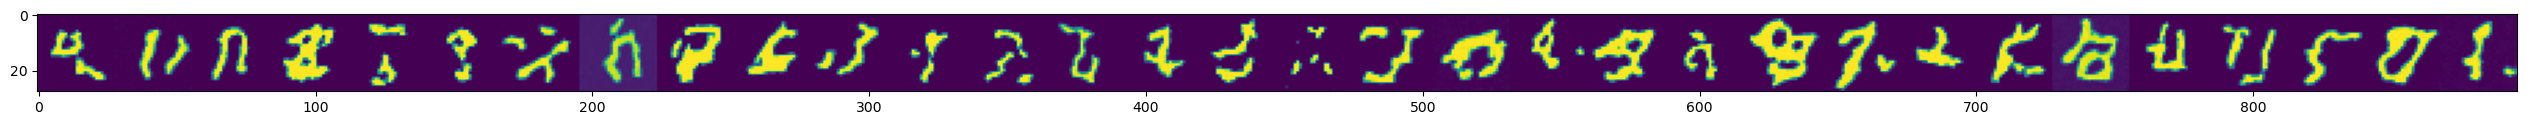

  1%|▊                                                                             | 1/100 [06:47<11:11:47, 407.15s/it]

Epoch [1/100] | Loss: 0.0258
out


999it [01:07, 14.72it/s]


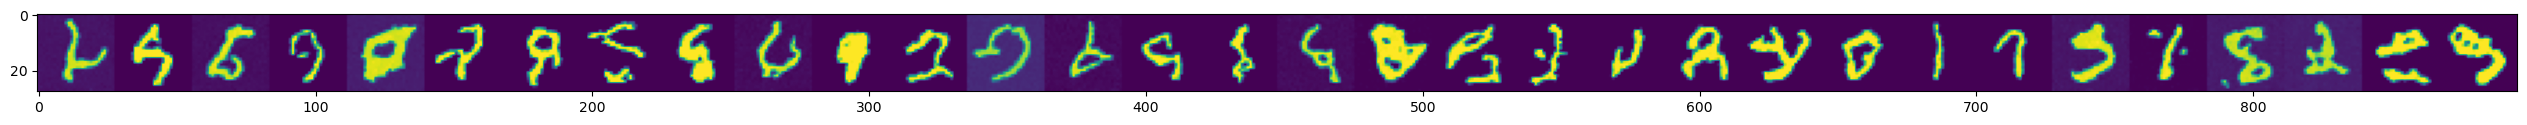

  2%|█▌                                                                            | 2/100 [13:30<11:01:30, 405.00s/it]

Epoch [2/100] | Loss: 0.0188
out


999it [01:08, 14.67it/s]


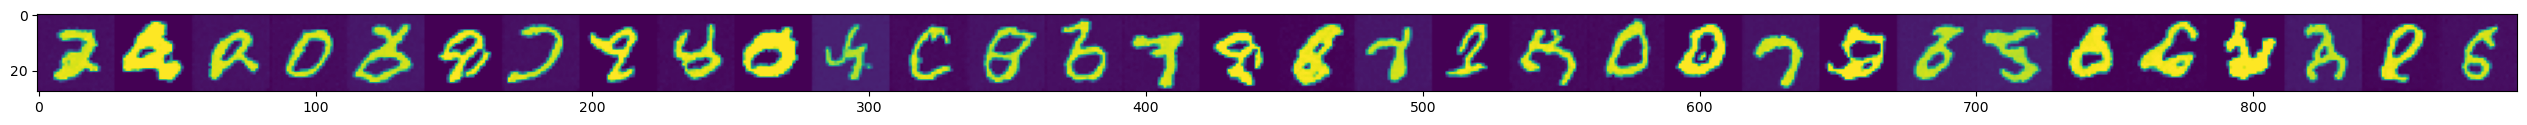

  3%|██▎                                                                           | 3/100 [20:15<10:54:32, 404.87s/it]

Epoch [3/100] | Loss: 0.0281
out


999it [01:33, 10.69it/s]


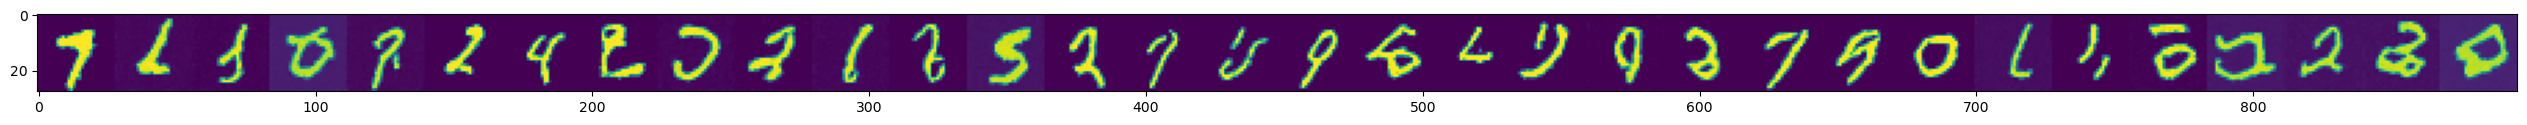

  4%|███                                                                           | 4/100 [27:56<11:23:18, 427.06s/it]

Epoch [4/100] | Loss: 0.0237
out


999it [01:07, 14.78it/s]


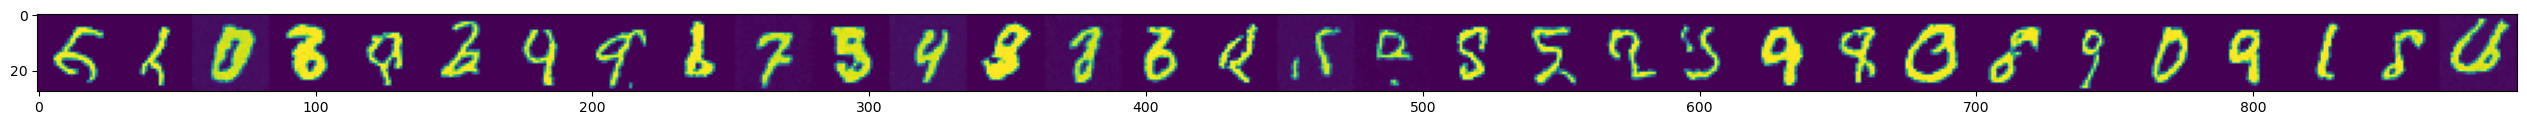

  5%|███▉                                                                          | 5/100 [34:53<11:10:19, 423.37s/it]

Epoch [5/100] | Loss: 0.0231
out


999it [01:07, 14.78it/s]


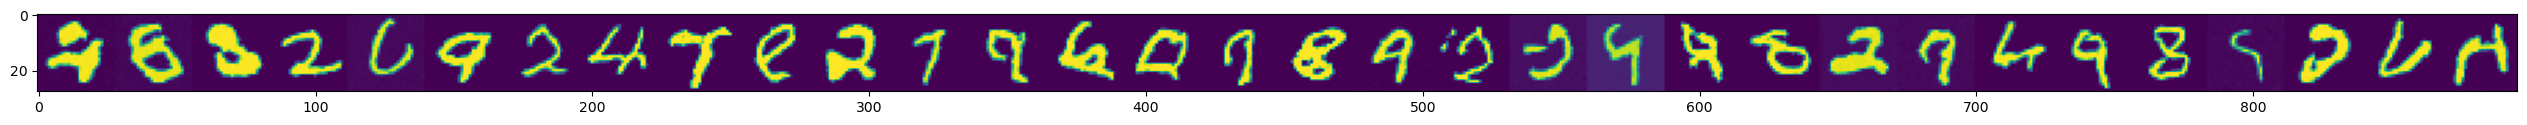

  6%|████▋                                                                         | 6/100 [41:35<10:52:16, 416.34s/it]

Epoch [6/100] | Loss: 0.0307
out


999it [01:07, 14.81it/s]


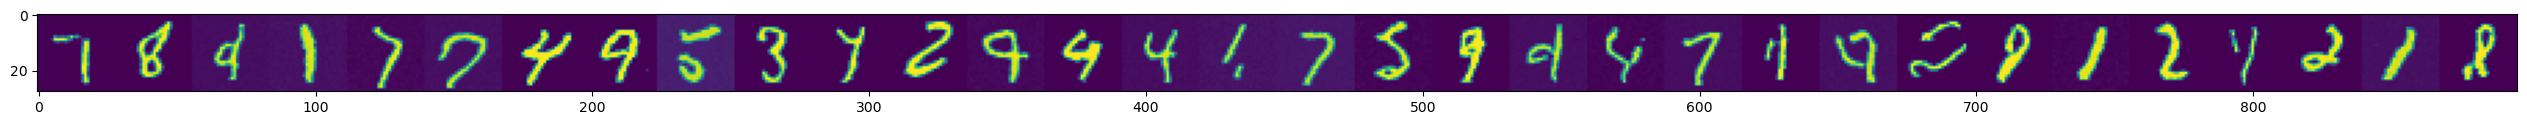

  7%|█████▍                                                                        | 7/100 [48:18<10:38:28, 411.91s/it]

Epoch [7/100] | Loss: 0.0235
out


999it [01:07, 14.72it/s]


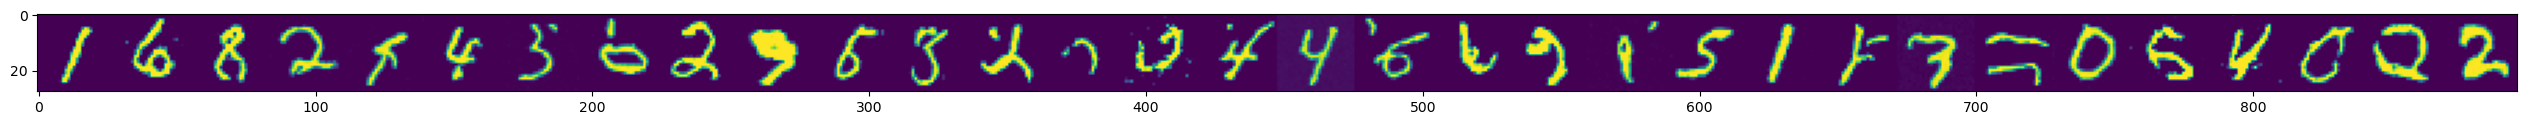

  8%|██████▏                                                                       | 8/100 [55:01<10:27:18, 409.11s/it]

Epoch [8/100] | Loss: 0.0256
out


999it [01:07, 14.71it/s]


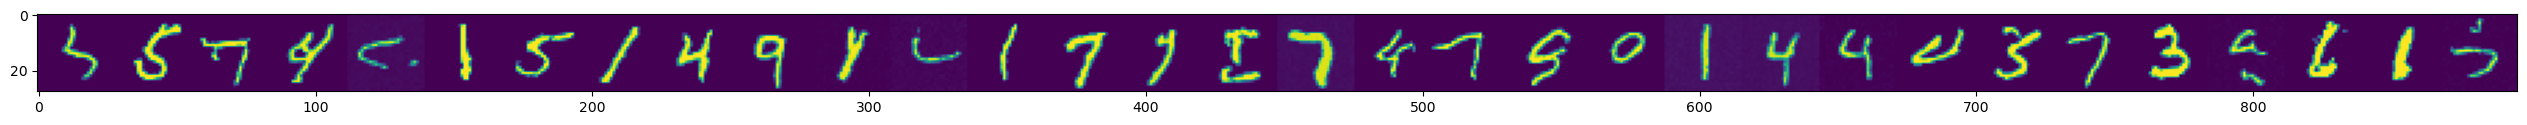

  9%|██████▊                                                                     | 9/100 [1:01:46<10:18:20, 407.69s/it]

Epoch [9/100] | Loss: 0.0270
out


999it [01:07, 14.76it/s]


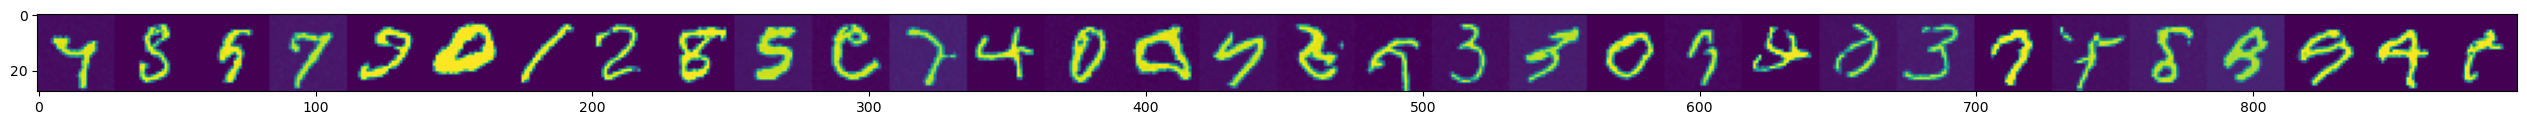

 10%|███████▌                                                                   | 10/100 [1:08:30<10:09:45, 406.51s/it]

Epoch [10/100] | Loss: 0.0148
out


999it [01:07, 14.74it/s]


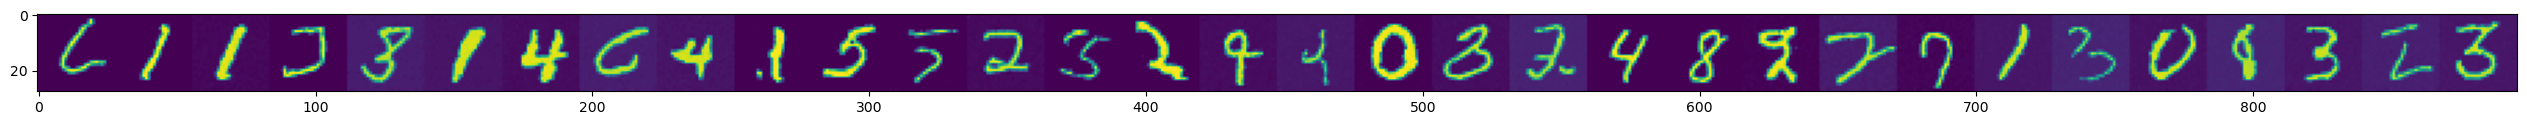

 11%|████████▎                                                                  | 11/100 [1:15:14<10:02:05, 405.90s/it]

Epoch [11/100] | Loss: 0.0186
out


999it [01:07, 14.70it/s]


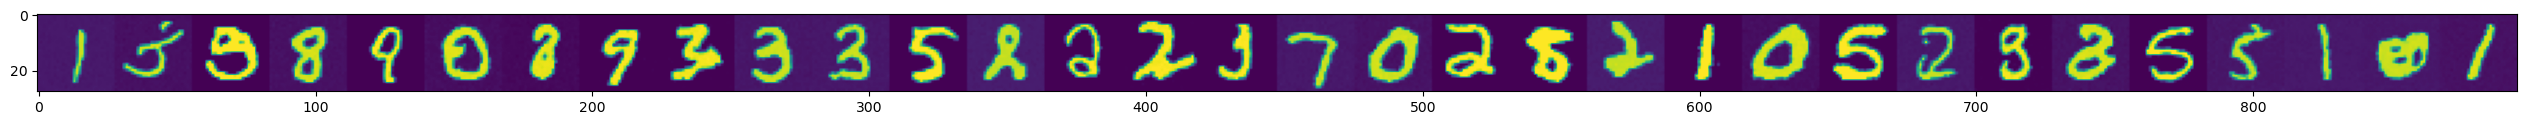

 12%|█████████                                                                   | 12/100 [1:21:59<9:54:43, 405.50s/it]

Epoch [12/100] | Loss: 0.0361
out


999it [01:30, 11.05it/s]


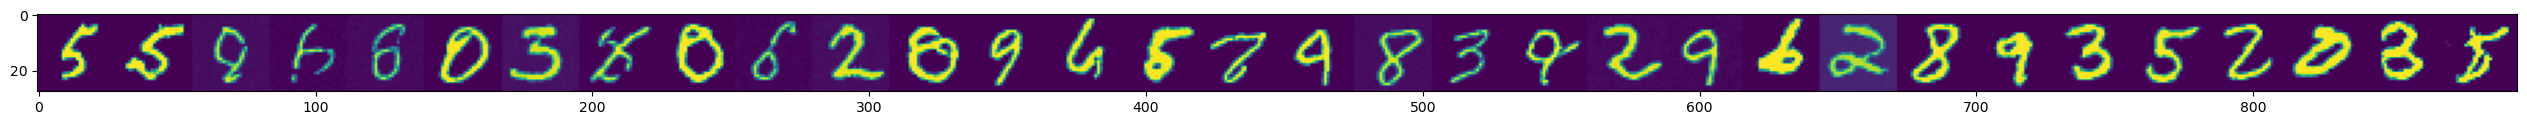

 13%|█████████▊                                                                 | 13/100 [1:29:37<10:11:04, 421.43s/it]

Epoch [13/100] | Loss: 0.0274
out


999it [01:07, 14.74it/s]


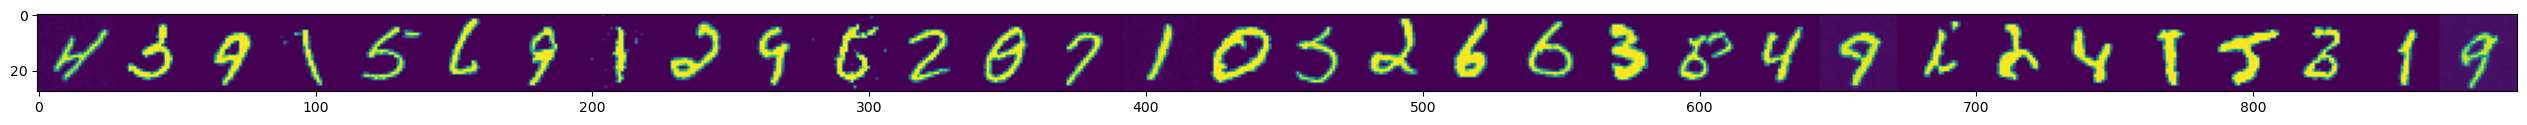

 14%|██████████▋                                                                 | 14/100 [1:36:19<9:55:27, 415.43s/it]

Epoch [14/100] | Loss: 0.0297
out


999it [01:08, 14.68it/s]


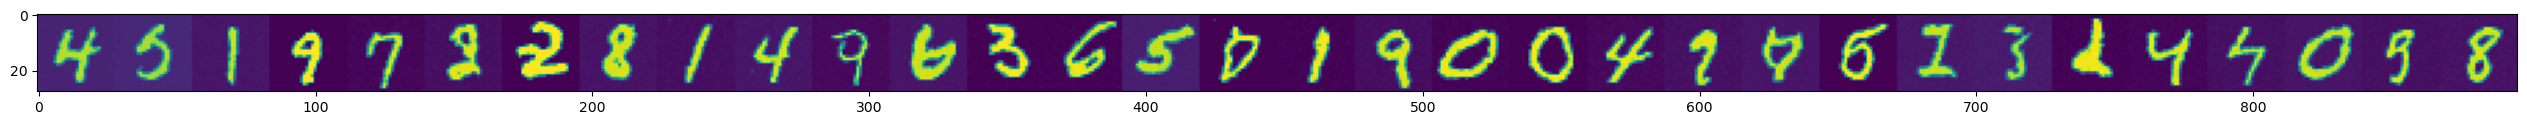

 15%|███████████▍                                                                | 15/100 [1:43:03<9:43:58, 412.22s/it]

Epoch [15/100] | Loss: 0.0227
out


999it [01:07, 14.70it/s]


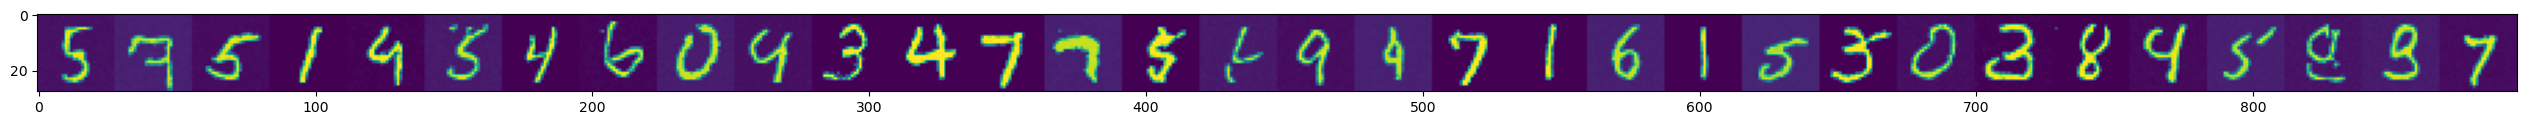

 16%|████████████▏                                                               | 16/100 [1:49:48<9:34:02, 410.03s/it]

Epoch [16/100] | Loss: 0.0242
out


999it [01:08, 14.67it/s]


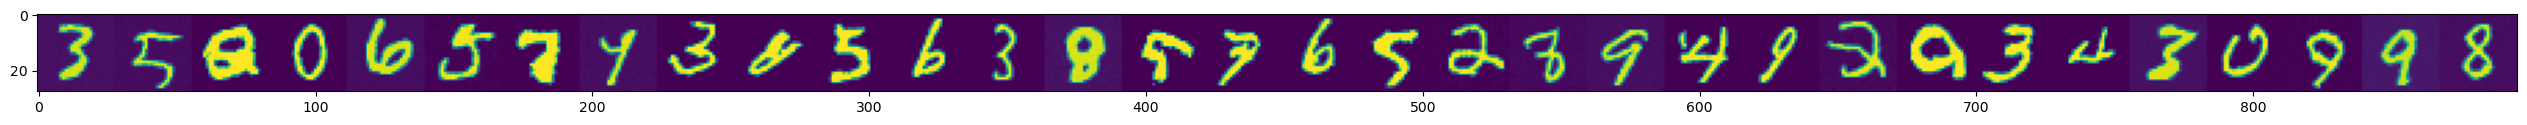

 17%|████████████▉                                                               | 17/100 [1:56:34<9:25:14, 408.61s/it]

Epoch [17/100] | Loss: 0.0191


In [ ]:
EPOCHS = 100
batch_size = 32
image_size = 28
learning_rate = 3e-4

# Import dataset
dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transforms, download=True)
train_loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

model = UNet().to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()
diffusion = Diffusion(img_size=image_size, device=device)
length = len(train_loader)

for epoch in tqdm(range(EPOCHS)):
    for x, _ in train_loader:
        optimizer.zero_grad()
        
        x = x.to(device)
        t = diffusion.sample_timesteps(x.shape[0]).to(device)
        x_t, noise = diffusion.noise_images(x, t)
        
        predicted_noise = model(x_t, t)
        loss = loss_fn(noise, predicted_noise)
        loss.backward()
        optimizer.step()
    print('out')
    sampled_images = diffusion.sample(model, n=x.shape[0])
    plot_images(sampled_images)
    print(f"Epoch [{epoch+1}/100] | Loss: {loss.item():.4f}")
        
